# Image Classification
In this project, you'll classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects. You'll preprocess the images, then train a convolutional neural network on all the samples. The images need to be normalized and the labels need to be one-hot encoded.  You'll get to apply what you learned and build a convolutional, max pooling, dropout, and fully connected layers.  At the end, you'll get to see your neural network's predictions on the sample images.
## Get the Data
Run the following cell to download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

All files found!


## Explore the Data
The dataset is broken into batches to prevent your machine from running out of memory.  The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:
* airplane 1
* automobile 2
* bird 3
* cat 4
* deer 5
* dog 6
* frog 7
* horse 8
* ship 9
* truck 10

* Total 10 classes (Aras changed above/this section a bit)

Understanding a dataset is part of making predictions on the data.  Play around with the code cell below by changing the `batch_id` and `sample_id`. The `batch_id` is the id for a batch (1-5). The `sample_id` is the id for a image and label pair in the batch.

Ask yourself "What are all possible labels?", "What is the range of values for the image data?", "Are the labels in order or random?".  Answers to questions like these will help you preprocess the data and end up with better predictions.


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 5:
Image - Min Value: 0 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


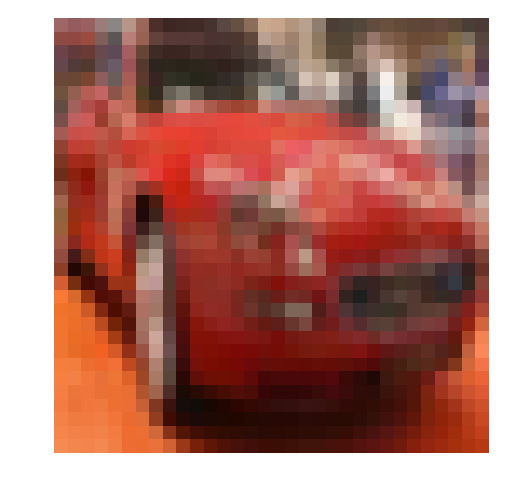

In [24]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 1
sample_id = 5
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Implement Preprocess Functions
### Normalize
In the cell below, implement the `normalize` function to take in image data, `x`, and return it as a normalized Numpy array. The values should be in the range of 0 to 1, inclusive.  The return object should be the same shape as `x`.

In [25]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    # TODO: Implement Function
    ## image data shape = [t, i,j,k], t= num_img_per_batch (basically the list of images), i,j,k=height,width, and depth/channel
    return x/255


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_normalize(normalize)

Tests Passed


### One-hot encode
Just like the previous code cell, you'll be implementing a function for preprocessing.  This time, you'll implement the `one_hot_encode` function. The input, `x`, are a list of labels.  Implement the function to return the list of labels as One-Hot encoded Numpy array.  The possible values for labels are 0 to 9. The one-hot encoding function should return the same encoding for each value between each call to `one_hot_encode`.  Make sure to save the map of encodings outside the function.

Hint: Don't reinvent the wheel.

In [26]:
# import helper ## I did this because sklearn.preprocessing was defined in there
from sklearn import preprocessing  ## from sklearn lib import preprocessing lib/sublib/functionality/class

def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    # TODO: Implement Function

    ## This was in the helper.py which belongs to the generic helper functions
    #     def display_image_predictions(features, labels, predictions):
    #     n_classes = 10
    #     label_names = _load_label_names()
    #     label_binarizer = LabelBinarizer()
    #     label_binarizer.fit(range(n_classes))
    #     label_ids = label_binarizer.inverse_transform(np.array(labels))
    label_binarizer = preprocessing.LabelBinarizer() ## instantiate and initialized the one-hot encoder from class to one-hot
    n_class = 10 ## total num_classes
    label_binarizer.fit(range(n_class)) ## fit the one-vec to the range of number of classes, 10 in this case (dataset)
    return label_binarizer.transform(x) ## transform the class labels to one-hot vec


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_one_hot_encode(one_hot_encode)

Tests Passed


## Preprocess all the data and save it
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation.

In [27]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# Implementation of CNN with backprop in NumPy

In [28]:
def get_im2col_indices(x_shape, field_height, field_width, padding=1, stride=1):
    # First figure out what the size of the output should be
    N, C, H, W = x_shape
    assert (H + 2 * padding - field_height) % stride == 0
    assert (W + 2 * padding - field_height) % stride == 0
    out_height = int((H + 2 * padding - field_height) / stride + 1)
    out_width = int((W + 2 * padding - field_width) / stride + 1)

    i0 = np.repeat(np.arange(field_height), field_width)
    i0 = np.tile(i0, C)
    i1 = stride * np.repeat(np.arange(out_height), out_width)
    j0 = np.tile(np.arange(field_width), field_height * C)
    j1 = stride * np.tile(np.arange(out_width), out_height)
    i = i0.reshape(-1, 1) + i1.reshape(1, -1)
    j = j0.reshape(-1, 1) + j1.reshape(1, -1)

    k = np.repeat(np.arange(C), field_height * field_width).reshape(-1, 1)

    return (k.astype(int), i.astype(int), j.astype(int))

In [29]:
def im2col_indices(x, field_height, field_width, padding=1, stride=1):
    """ An implementation of im2col based on some fancy indexing """
    # Zero-pad the input
    p = padding
    x_padded = np.pad(x, ((0, 0), (0, 0), (p, p), (p, p)), mode='constant')

    k, i, j = get_im2col_indices(x.shape, field_height, field_width, padding, stride)

    cols = x_padded[:, k, i, j]
    C = x.shape[1]
    cols = cols.transpose(1, 2, 0).reshape(field_height * field_width * C, -1)
    return cols

In [30]:
def col2im_indices(cols, x_shape, field_height=3, field_width=3, padding=1,
                   stride=1):
    """ An implementation of col2im based on fancy indexing and np.add.at """
    N, C, H, W = x_shape
    H_padded, W_padded = H + 2 * padding, W + 2 * padding
    x_padded = np.zeros((N, C, H_padded, W_padded), dtype=cols.dtype)
    k, i, j = get_im2col_indices(x_shape, field_height, field_width, padding, stride)
    cols_reshaped = cols.reshape(C * field_height * field_width, -1, N)
    cols_reshaped = cols_reshaped.transpose(2, 0, 1)
    np.add.at(x_padded, (slice(None), k, i, j), cols_reshaped)
    if padding == 0:
        return x_padded
    return x_padded[:, :, padding:-padding, padding:-padding]

In [31]:
def conv_forward(X, W, b, stride=1, padding=1):
    cache = W, b, stride, padding
    n_filters, d_filter, h_filter, w_filter = W.shape
    n_x, d_x, h_x, w_x = X.shape
    h_out = (h_x - h_filter + 2 * padding) / stride + 1
    w_out = (w_x - w_filter + 2 * padding) / stride + 1

    if not h_out.is_integer() or not w_out.is_integer():
        raise Exception('Invalid output dimension!')

    h_out, w_out = int(h_out), int(w_out)

    X_col = im2col_indices(X, h_filter, w_filter, padding=padding, stride=stride)
    W_col = W.reshape(n_filters, -1)

    out = W_col @ X_col + b
    out = out.reshape(n_filters, h_out, w_out, n_x)
    out = out.transpose(3, 0, 1, 2)

    cache = (X, W, b, stride, padding, X_col)

    return out, cache

In [32]:
def conv_backward(dout, cache):
    X, W, b, stride, padding, X_col = cache
    n_filter, d_filter, h_filter, w_filter = W.shape

    db = np.sum(dout, axis=(0, 2, 3))
    db = db.reshape(n_filter, -1)

    dout_reshaped = dout.transpose(1, 2, 3, 0).reshape(n_filter, -1)
    dW = dout_reshaped @ X_col.T
    dW = dW.reshape(W.shape)

    W_reshape = W.reshape(n_filter, -1)
    dX_col = W_reshape.T @ dout_reshaped
    dX = col2im_indices(dX_col, X.shape, h_filter, w_filter, padding=padding, stride=stride)

    return dX, dW, db

In [33]:
# Now it is time to calculate the error using cross entropy
def cross_entropy(y_pred, y_train):
    m = y_pred.shape[0]

    prob = softmax(y_pred)
    log_like = -np.log(prob[range(m), y_train])

    data_loss = np.sum(log_like) / m
    #     reg_loss = regularization(model, reg_type='l2', lam=lam)

    return data_loss # + reg_loss

def dcross_entropy(y_pred, y_train):
    m = y_pred.shape[0]

    grad_y = softmax(y_pred)
    grad_y[range(m), y_train] -= 1.
    grad_y /= m

    return grad_y

In [74]:
# Softmax and sidmoid are equally based on Bayesian NBC/ Naiive Bayesian Classifer as a probability-based classifier
def softmax(X):
    eX = np.exp((X.T - np.max(X, axis=1)).T)
    return (eX.T / eX.sum(axis=1)).T

def dsoftmax(X, sX): # derivative of the softmax which is the same as sigmoid as softmax is sigmoid and bayesian function for probabilistic classfication
    # X is the input to the softmax and sX is the sX=softmax(X)
    grad = np.zeros(shape=(len(sX[0]), len(X[0])))
    
    # Start filling up the gradient
    for i in range(len(sX[0])): # mat_1xn, n=num_claess, 10 in  this case
        for j in range(len(X[0])):
            if i==j: 
                grad[i, j] = (sX[0, i] * (1-sX[0, i]))
            else: 
                grad[i, j] = (-sX[0, i]* sX[0, j])
    # return the gradient as the derivative of softmax/bwd softmax layer
    return grad

def sigmoid(X):
    return 1. / (1 + np.exp(-X))

def dsigmoid(X):
    return sigmoid(X) * (1-sigmoid(X))

In [75]:
def squared_loss(y_pred, y_train):
    m = y_pred.shape[0]
    data_loss = (0.5/m) * np.sum(y_pred - y_train)**2 # This is now convex error surface x^2 
    return data_loss #+ reg_loss

def dsquared_loss(y_pred, y_train):
    m = y_pred.shape[0]
    grad_y = (y_pred - y_train)/m # f(x)-y is the convex surface for descending/minimizing
    return grad_y

In [60]:
from sklearn.utils import shuffle as sklearn_shuffle

def get_minibatch(X, y, minibatch_size, shuffle=True):
    minibatches = []

    if shuffle:
        X, y = sklearn_shuffle(X, y)

    for i in range(0, X.shape[0], minibatch_size):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]

        minibatches.append((X_mini, y_mini))

    return minibatches

# Check Point
This is your first checkpoint.  If you ever decide to come back to this notebook or have to restart the notebook, you can start from here.  The preprocessed data has been saved to disk.

In [37]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

# This is where the CNN imllementation in NumPy starts!

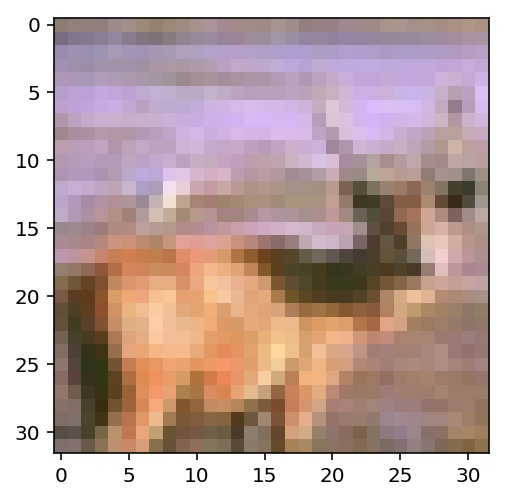

In [38]:
# Displaying an image using matplotlib
# importing the library/package
import matplotlib.pyplot as plot

# Using plot with imshow to show the image (N=5000, H=32, W=32, C=3)
plot.imshow(valid_features[0, :, :, :])

In [39]:
# # Training cycle
#     for epoch in range(num_):
#         # Loop over all batches
#         n_batches = 5
#         for batch_i in range(1, n_batches + 1):
#             for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
#                 train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
#             print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
#             print_stats(sess, batch_features, batch_labels, cost, accuracy)


Epoch: 0 Error: 0.45008646682
Epoch: 1 Error: 0.449997899769
Epoch: 2 Error: 0.449996336761
Epoch: 3 Error: 0.449994805444
Epoch: 4 Error: 0.449993304455
Epoch: 5 Error: 0.449991833198
Epoch: 6 Error: 0.449990391089
Epoch: 7 Error: 0.449988977555
Epoch: 8 Error: 0.449987592032
Epoch: 9 Error: 0.449986233971
Epoch: 10 Error: 0.449984902832
Epoch: 11 Error: 0.449983598083
Epoch: 12 Error: 0.449982319207
Epoch: 13 Error: 0.449981065693
Epoch: 14 Error: 0.449979837043
Epoch: 15 Error: 0.449978632767
Epoch: 16 Error: 0.449977452386
Epoch: 17 Error: 0.449976295428
Epoch: 18 Error: 0.449975161432
Epoch: 19 Error: 0.449974049946
Epoch: 20 Error: 0.449972960526
Epoch: 21 Error: 0.449971892738
Epoch: 22 Error: 0.449970846154
Epoch: 23 Error: 0.449969820358
Epoch: 24 Error: 0.449968814939
Epoch: 25 Error: 0.449967829495
Epoch: 26 Error: 0.449966863632
Epoch: 27 Error: 0.449965916964
Epoch: 28 Error: 0.449964989113
Epoch: 29 Error: 0.449964079705
Epoch: 30 Error: 0.449963188379
Epoch: 31 Error: 0.

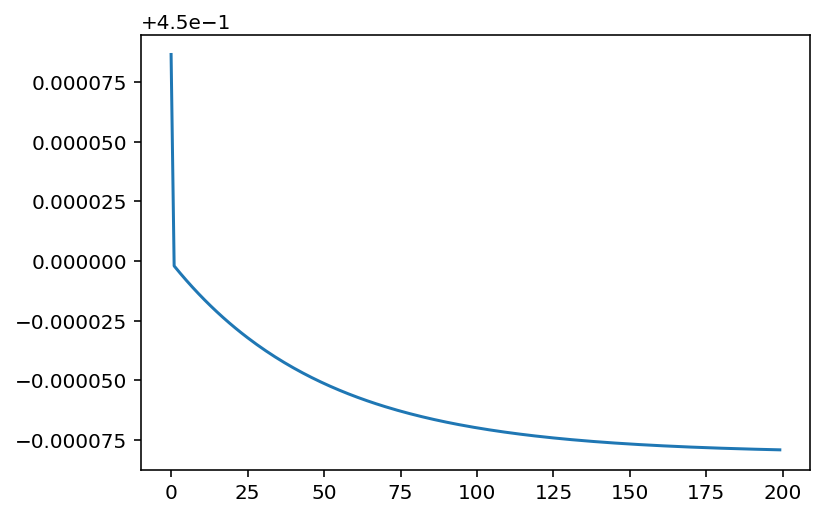

In [84]:
# # input and output dataset
X=valid_features.transpose(0, 3, 1, 2) # NCHW == mat_txn
Y=valid_labels #NH= num_classes=10 = mat_txn
#for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
# train_features, train_labels = helper.load_preprocess_training_batch(batch_id=, batch_size=)



# Initilizting the parameters
# Convolutional layer
# Suppose we have 20 of 3x3 filter: 20x1x3x3. W_col will be 20x9 matrix
# Let this be 3x3 convolution with stride = 1 and padding = 1
h_filter=3 
w_filter=3 
c_filter=3
padding=1 
stride=1
num_filters = 20
w1 = np.random.normal(loc=0.0, scale=1.0, size=(num_filters, c_filter, h_filter, w_filter))# NCHW 20x9 x 9x500 = 20x500
w1 = w1/(c_filter* h_filter* w_filter) # taking average from them or average running for initialization.
b1 = np.zeros(shape=(num_filters, 1), dtype=float)

# FC layer to the output layer -- This is really hard to have a final size for the FC to the output layer
# num_classes = y[0, 1] # txn
w2 = np.random.normal(loc=0.0, scale=1.0, size=Y[0:1].shape) # This will be resized though
b2 = np.zeros(shape=Y[0:1].shape) # number of output nodes/units/neurons are equal to the number of classes

# Initializing hyper parameters
num_epochs = 200
## minibatch_size = 512 # This will eventually used for stochstic or random minibatch from the whole batch
batch_size = X.shape[0]//1 #NCHW, N= number of samples or t
error_list = [] # to display the plot or plot the error curve/ learning rate

# Training loops for epochs and updating params
for epoch in range(num_epochs): # start=0, stop=num_epochs, step=1

    # Initializing/reseting the gradients
    dw1 = np.zeros(shape=w1.shape)
    db1 = np.zeros(shape=b1.shape)
    dw2 = np.zeros(shape=w2.shape)
    db2 = np.zeros(shape=b2.shape)
    err = 0
    
    #     # Shuffling the entire batch for a minibatch
    #     # Stochastic part for randomizing/shuffling through the dataset in every single epoch
    #     minibatches = get_minibatch(X=X, y=Y, minibatch_size=batch_size, shuffle=True)
    #     X_mini, Y_mini = minibatches[0]
    
    
    # The loop for learning the gradients
    for t in range(batch_size): # start=0, stop=mini_batch_size/batch_size, step=1
        
        # input and output each sample in the batch/minibatch for updating the gradients/d_params/delta_params
        x= X[t:t+1] # mat_nxcxhxw
        y= Y[t:t+1] # mat_txm
        #         print("inputs:", x.shape, y.shape)
        
        # Forward pass
        # start with the convolution layer forward
        h1_in, h1_cache = conv_forward(X=x, W=w1, b=b1, stride=1, padding=1)
        h1_out = h1_in * 1 # activation func. = LU
        #h1_out = np.maximum(h1_in, 0) # ReLU for avoiding the very high ERROR in classification
        #         print("Convolution layer:", h1_out)

        # Connect the flattened layer to the output layer/visible layer FC layer
        h1_fc = h1_out.reshape(1, -1)
        # initializing w2 knowing the size/given the size of fc layer
        if t==0: w2 = (1/h1_fc.shape[1]) * np.resize(a=w2, new_shape=(h1_fc.shape[1], y.shape[1])) # mat_hxm # initialization
        out = h1_fc @ w2 + b2
        y_prob = softmax(X=out) # can also be sigmoid/logistic function/Bayesina/ NBC
        #         print("Output layer: ", out, y_prob, y)

        # Mean Square Error: Calculate the error one by one sample from the batch -- Euclidean distance
        err += 0.5 * (1/ batch_size) * np.sum((y_prob - y)**2) # convex surface ax2+b
        dy = (1/ batch_size) * (y_prob - y) # convex surface this way # ignoring the constant coefficies
        #         print("error:", dy, err)
        
        #         # Mean Cross Entropy Error: np.log is np.log(exp(x))=x equals to ln in math
        #         err += (1/batch_size) * -(np.sum(y* np.log(y_prob))) 
        #         dy = (1/batch_size) * -(y/ y_prob) # y_prop= 0-1, log(y_prob)==-inf-0
        #         #         print("Error:", dy, err)

        # Backward pass
        # output layer gradient
        dout = dy @ dsoftmax(X=out, sX=y_prob).T
        if t==0: dw2 = np.resize(a=dw2, new_shape=w2.shape)
        dw2 += h1_fc.T @ dout # mat_hx1 @ mat_1xm = mat_hxm
        db2 += dout # mat_1xm
        dh1_fc = dout @ w2.T # mat_1xm @ mat_mxh

        # convolution layer back
        dh1_out = dh1_fc.reshape(h1_out.shape)
        #         dh1[h1_out<=0] = 0 #drelu
        dh1 = dh1_out * 1 # derivative of the LU in bwd pass/prop
        dX_conv, dW_conv, db_conv = conv_backward(cache=h1_cache, dout=dh1)
        dw1 += dW_conv
        db1 += db_conv

    # Updating the params in the model/cnn in ech epoch 
    w1 -= dw1
    b1 -= db1
    w2 -= dw2
    b2 -= db2

    # displaying the total error and accuracy
    print("Epoch:", epoch, "Error:", err)
    error_list.append(err)

# Ploting the error list for the learning rate

plot.plot(error_list)

In [82]:
error_list_MCE = error_list

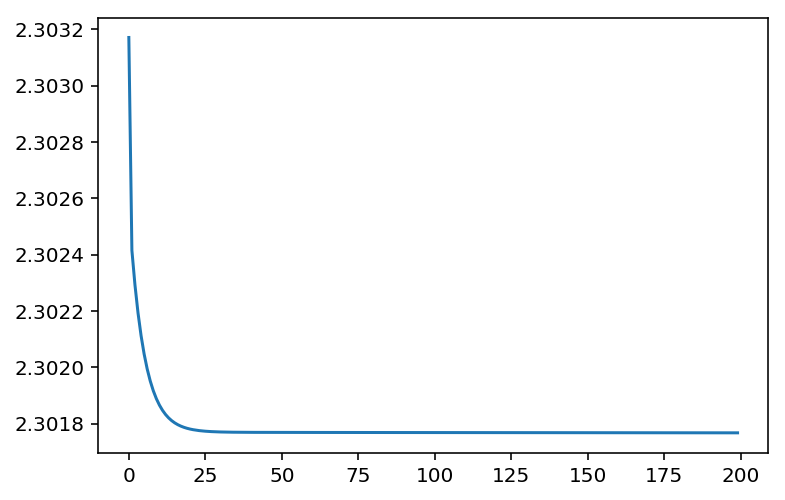

In [83]:
plot.plot(error_list_MCE)

In [85]:
error_list_MSE = error_list

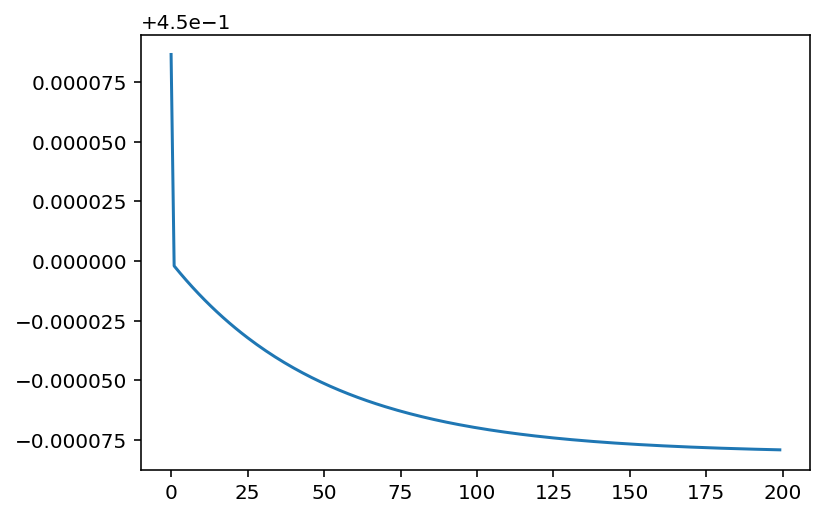

In [86]:
plot.plot(error_list_MSE)